# Objetivo

O presente estudo realizará uma análise abrangente sobre os dados da Sídrome Respiratória Aguda Grave (SRAG), no período de 2023, dados estes advindos do OpenDataSus (https://opendatasus.saude.gov.br/dataset/srag-2021-a-2024).

Objetivando o auxílio na tomada de decisão de forma assertiva, serão realizados estudos relacionado as características abordadas nos dados, bem como sua correlação com o objeto de interesse, 
través da observação dos padrões de SRAG, para auxílio na tomada de decisão de forma acertiva, relacionadas ao setor de saúde.

# Import de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (make_scorer, roc_auc_score, average_precision_score,
                                  precision_score, recall_score, f1_score,
                                  accuracy_score, confusion_matrix,
                                  RocCurveDisplay, PrecisionRecallDisplay, classification_report)


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Import da base de dados

In [2]:
# caminho da base de dados
path = "INFLUD23-26-06-2025.csv"
srag = pd.read_csv(path, sep = ";")

print(f"Formato do DataFrame: {srag.shape}")

Formato do DataFrame: (279453, 194)


In [3]:
# visualização do dataframe inicial
srag.head()

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,FATOR_RISC,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,MORB_DESC,TABAG,VACINA,DT_UT_DOSE,MAE_VAC,DT_VAC_MAE,M_AMAMENTA,DT_DOSEUNI,DT_1_DOSE,DT_2_DOSE,ANTIVIRAL,TP_ANTIVIR,OUT_ANTIV,DT_ANTIVIR,HOSPITAL,DT_INTERNA,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE,NM_UN_INTE,UTI,DT_ENTUTI,DT_SAIDUTI,SUPORT_VEN,RAIOX_RES,RAIOX_OUT,DT_RAIOX,AMOSTRA,DT_COLETA,TP_AMOSTRA,OUT_AMOST,PCR_RESUL,DT_PCR,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,FLUASU_OUT,PCR_FLUBLI,FLUBLI_OUT,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DS_PCR_OUT,CLASSI_FIN,CLASSI_OUT,CRITERIO,EVOLUCAO,DT_EVOLUCA,DT_ENCERRA,DT_DIGITA,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,POV_CT,TP_POV_CT,TEM_CPF,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,DOSE_2REF,DOSE_ADIC,DOS_RE_BI,FAB_COV_1,FAB_COV_2,FAB_COVRF,FAB_COVRF2,FAB_ADIC,FAB_RE_BI,LOTE_1_COV,LOTE_2_COV,LOTE_REF,LOTE_REF2,LOTE_ADIC,LOT_RE_BI,FNT_IN_COV,TRAT_COV,TIPO_TRAT,DT_TRT_COV,OUT_TRAT,SURTO_SG,CO_DETEC,VG_OMS,VG_OMSOUT,VG_LIN,VG_MET,VG_METOUT,VG_DTRES,VG_ENC,VG_REINF,VG_CODEST,REINF
0,316004370301,2023-02-07,6,2023-02-05,6,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,F,1941-06-30,81,3,3081,6,1,NaN,1.0,BRASIL,1,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,1.0,2.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,RNC,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,ACAMADA HA 12 ANOS,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,2023-02-07,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,HOSPITAL MUNICIPAL DE EMERGENCIAS ALBERT SABIN,2.0,NaN,NaN,3.0,6.0,NaN,NaN,1.0,2023-02-07,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,2.0,2023-02-08,2023-02-09,2020-09-18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2.0,2023-02-07,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2.0,1.0,10/03/2021,07/04/2021,06/04/2022,06/04/2022,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,88 - COVID-19 JANSSEN - AD26.COV2.S,88 - COVID-19 JANSSEN - AD26.COV2.S,NaN,NaN,202010034,210083,210F21A,210F21A,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,316153805701,2023-02-28,9,2023-01-17,3,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,M,1933-12-10,89,3,3089,6,1,NaN,1.0,BRASIL,1,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,QUEDA DO ESTADO GERAL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NEO PROSTATA/HIPOTIREOIDISMO,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,2023-01-17,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,HOSPITAL MUNICIPAL DE EMERGENCIAS ALBERT SABIN,2.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,2023-01-17,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,2.0,2023-02-26,2023-02-28,2021-03-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2023-01-17,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2.0,1.0,12/02/2021,05/04/2021,13/10/2021,NaN,NaN,NaN,86 - COVID-19 SINOVAC/

# Seleção inicial das características a serem utilizadas na base de dados de avaliação

Há uma grande quantidade de valores ausentes (missing) na base de dados, portanto, levar características com volumetria elevada de dados não preenchidos, possívelmente, atrapalhará o modelo de encontrar padrões. Então, selecionaremos para este estudo inicial apenas dados que possuem um percentual de preenchimento de o mínimo 80%.

Desta forma, trabalharemos com uma base com mais qualidade, no que tange ao preenchimento de informações, bem como reduziremos a dimensionalidade da tabela trabalhada. Vale ressaltar que, caso a área de negócio defina que uma das variáveis retiradas possuam um forte impacto no objeto de interesse, seria necessário a utilização de outras bases de dados complementares para que se utilize dados com maior qualidade e menor interferência dos analista, que seria o caso da necessidade de imputar valores como média, mediana, entre outras.

Sabedo que podem haver features que possuem apenas 1 valor único, logo, utilizar essas características não irá trazer benefícios ao modelo ou análises, dado que seu valor será o mesmo independente do resultado final, ou seja, como não possuem variabilidade não trazem poder explicativo para os modelos, nem mesmo valores informativos para as análises.

Logo, vamos retirar essas colunas da base de dados.

In [4]:
# removendo features com apenas um único valor
lista_feat_sem_variancia = srag.nunique()[srag.nunique() == 1].index.tolist()
srag = srag.drop(columns = lista_feat_sem_variancia)

In [5]:
# vamos verificar a qualidade das colunas, visualizando a quantidade de valores ausentes, buscando reduzir a dimensionalidade da base de dados inicial
# selecionando colunas com pelo meons 80% de preenchimento
percentual_preenchimento = 100 * srag.notnull().mean()
features_preechidas = percentual_preenchimento[percentual_preenchimento >= 80].sort_values(ascending = False)

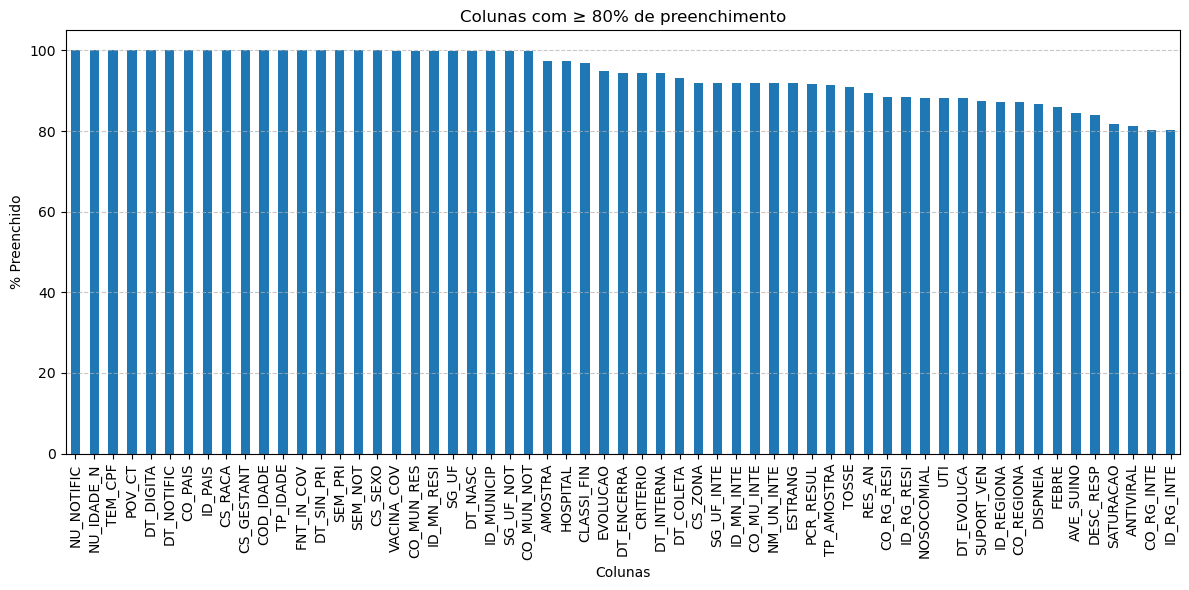

In [6]:
# visualizando o percentual que está preenchido dos dados, verificando a qualidade do dataframe
plt.figure(figsize=(12, 6))
features_preechidas.plot(kind='bar')
plt.title('Colunas com ≥ 80% de preenchimento')
plt.ylabel('% Preenchido')
plt.xlabel('Colunas')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Filtrando apenas colunas com preenchimento ≥ 80%
colunas_completas = percentual_preenchimento[percentual_preenchimento >= 80].index
srag_reduzido = srag[colunas_completas]

# Cria DataFrame de metadados
resumo_caracteristicas = pd.DataFrame({
    'tipo': srag_reduzido.dtypes,
    '% preenchido': percentual_preenchimento[colunas_completas],
    'cardinalidade': srag_reduzido.nunique()
})

# Ordena por menor percentual preenchido (para facilitar análise de borda dos 80%)
resumo_caracteristicas = resumo_caracteristicas.sort_values(by='% preenchido')

resumo_caracteristicas.head(100)

,tipo,% preenchido,cardinalidade
CO_RG_INTE,float64,80.213846,297
ID_RG_INTE,object,80.213846,297
ANTIVIRAL,float64,81.340333,3
SATURACAO,float64,81.721077,3
DESC_RESP,float64,83.887452,3
AVE_SUINO,float64,84.514033,4
FEBRE,float64,85.961861,3
DISPNEIA,float64,86.747682,3
ID_REGIONA,object,87.298759,300
CO_REGIONA,float64,87.298759,300


In [8]:
print(f'Portanto, temos uma base de dados inicial com: {srag_reduzido.shape[1]-1} colunas/features a serem trabalhadas e uma variável de target chamada "EVOLUCAO" que trata da evolução dos casos de SRAG')

Portanto, temos uma base de dados inicial com: 58 colunas/features a serem trabalhadas e uma variável de target chamada "EVOLUCAO" que trata da evolução dos casos de SRAG


In [9]:
# visualizando a variável target
print(f'Número de valores únicos da nossa variável target: {srag_reduzido["EVOLUCAO"].nunique()}')

# sabendo que a variável target possuem 4 valores sendo eles codificados como 1 = Cura; 2 = Óbito; 3 = Óbito por outras causas; 4 = Ignorado; Segundo o dicionário de dados disponível pelo Open Data Sus.
# Temos que remover os dados que possuem as codificações 3 e 4, dados que nosso objetivo é verificar os casos de SRAG.
# Também temos a necessidade de remover valores missing
print (f"Número de linhas antes do tratamento: {srag_reduzido.shape[0]}")
display(pd.DataFrame(srag_reduzido['EVOLUCAO'].value_counts()))
srag_reduzido = srag_reduzido[srag_reduzido['EVOLUCAO'].isin([1,2])]
print (f"Número de linhas após do tratamento: {srag_reduzido.shape[0]}")
display(pd.DataFrame(srag_reduzido['EVOLUCAO'].value_counts()))

Número de valores únicos da nossa variável target: 4
Número de linhas antes do tratamento: 279453


,count
EVOLUCAO,
1.0,226151
2.0,24944
3.0,8301
9.0,6077


Número de linhas após do tratamento: 251095


,count
EVOLUCAO,
1.0,226151
2.0,24944


In [10]:
# vamos alterar a coluna EVOLUCAO para 0 = cura e 1 = óbito
srag_reduzido['EVOLUCAO'] = srag_reduzido['EVOLUCAO'].replace({1:0, 2:1})

Agora, que finalizamos o tratamento inicial da base de dados podemos separar os dados em Treino e Teste, para que não ocorra o vazamento de informações dos dados de teste para o dados de treino, o que chamamos de data leakage, e nosso modelo não fique enviesado.

Vale salientar que o tratamento que fizemos até agora não afeta a informação que os dados trarão, nem mesmo a alteração de dados nas tabelas, como por exemplo: imputação de valores em dados ausentes.

# Separação da base em treino e teste

Temos que separar em dois grupos principais, dados de Treinamento e dados de Teste. O grupo de treinamento será aquele em que iremos avaliar as tendências do modelo, fazer análises de correlações e avaliar padrões, enquanto o grupo de teste servirá como dados simulados do ambiente de produção, em que avaliaremos como o modelo está generalizando, se ele está ajustando demais aos dados de treinamentos ou o inverso, absorvendo pouco dos padrões. Ambos os resultados afetam a performance do modelo e seu potencial preditivo.

In [11]:
from sklearn.model_selection import train_test_split
# separando nossos dados em treino e teste
X = srag_reduzido.drop(columns = 'EVOLUCAO')
y = srag_reduzido['EVOLUCAO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
# avaliando o número de linhas e colunas após a separação em treino e teste para conferir a volumetria
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((200876, 58), (50219, 58), (200876,), (50219,))

# Análise Exploratória dos Dados (EDA)

In [13]:
# vamos começar entendendo as variáveis que temos no nosso banco de dados
X_train.head()

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,DISPNEIA,DESC_RESP,SATURACAO,ANTIVIRAL,HOSPITAL,DT_INTERNA,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE,NM_UN_INTE,UTI,SUPORT_VEN,AMOSTRA,DT_COLETA,TP_AMOSTRA,PCR_RESUL,CLASSI_FIN,CRITERIO,DT_EVOLUCA,DT_ENCERRA,DT_DIGITA,RES_AN,POV_CT,TEM_CPF,ESTRANG,VACINA_COV,FNT_IN_COV
102568,31684235780119,2023-05-16,20,2023-05-14,20,SE,REGIONAL ARACAJU,2056.0,ARACAJU,280030.0,M,2023-03-10,2,2,2002,6,9,BRASIL,1,SE,REGIONAL ARACAJU,2056.0,SAO CRISTOVAO,280670.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2023-05-14,SE,REGIONAL ARACAJU,2056.0,ARACAJU,280030.0,HOSPITAL GABRIEL SOARES,2.0,3.0,2.0,NaN,NaN,NaN,4.0,1.0,2023-05-19,2023-06-21,2023-05-16,NaN,2,1,2.0,2.0,2
215330,31695990609256,2023-09-20,38,2023-09-15,37,SP,GVE XXXI SOROCABA,1353.0,SOROCABA,355220.0,M,2023-07-16,2,2,2002,6,1,BRASIL,1,SP,GVE XXXI SOROCABA,1353.0,SOROCABA,355220.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2023-09-20,SP,GVE XXXI SOROCABA,1353.0,SOROCABA,355220.0,HOSPITAL GPACI SOROCABA,2.0,2.0,1.0,2023-09-20,2.0,2.0,4.0,1.0,2023-09-28,2023-09-28,2023-09-29,5.0,2,1,2.0,2.0,2
261498,31702302214868,2023-12-11,50,2023-12-08,49,SP,GVE XXIII REGISTRO,1347.0,PARIQUERA-ACU,353620.0,M,1965-02-26,58,3,3058,6,2,BRASIL,1,SP,GVE XXIII REGISTRO,1347.0,REGISTRO,354260.0,3.0,1.0,9.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2023-12-08,SP,GVE XXIII REGISTRO,1347.0,PARIQUERA-ACU,353620.0,HOSPITAL DR LEOPOLDO BEVILACQUA,2.0,3.0,1.0,2023-12-08,1.0,4.0,5.0,NaN,2023-12-09,2023-12-11,2023-12-11,1.0,2,1,2.0,1.0,2
192551,31692893584308,2023-08-16,33,2023-08-16,33,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880.0,M,2021-12-14,1,3,3001,6,1,BRASIL,1,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2023-08-16,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880.0,UNIMED DE GUARULHOS COOPERATIVA DE TRABALHO ME...,2.0,3.0,1.0,2023-08-16,1.0,4.0,3.0,1.0,2023-08-19,2023-08-24,2023-08-24,2.0,2,1,2.0,2.0,2
82294,31682508146338,2023-04-04,14,2023-03-28,13,TO,NaN,NaN,PALMAS,172100.0,M,1930-01-23,93,3,3093,6,9,BRASIL,1,TO,NaN,NaN,MIRACEMA DO TOCANTINS,171320.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2023-04-03,1.0,1.0,5.0,NaN,2023-04-09,2023-04-09,2023-04-26,5.0,2,1,2.0,1.0,2


In [14]:
srag_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251095 entries, 0 to 279452
Data columns (total 59 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NU_NOTIFIC  251095 non-null  int64  
 1   DT_NOTIFIC  251095 non-null  object 
 2   SEM_NOT     251095 non-null  int64  
 3   DT_SIN_PRI  251095 non-null  object 
 4   SEM_PRI     251095 non-null  int64  
 5   SG_UF_NOT   251048 non-null  object 
 6   ID_REGIONA  219188 non-null  object 
 7   CO_REGIONA  219188 non-null  float64
 8   ID_MUNICIP  251048 non-null  object 
 9   CO_MUN_NOT  251048 non-null  float64
 10  CS_SEXO     251095 non-null  object 
 11  DT_NASC     251021 non-null  object 
 12  NU_IDADE_N  251095 non-null  int64  
 13  TP_IDADE    251095 non-null  int64  
 14  COD_IDADE   251095 non-null  object 
 15  CS_GESTANT  251095 non-null  int64  
 16  CS_RACA     251095 non-null  int64  
 17  ID_PAIS     251095 non-null  object 
 18  CO_PAIS     251095 non-null  int64  
 19  SG_UF  

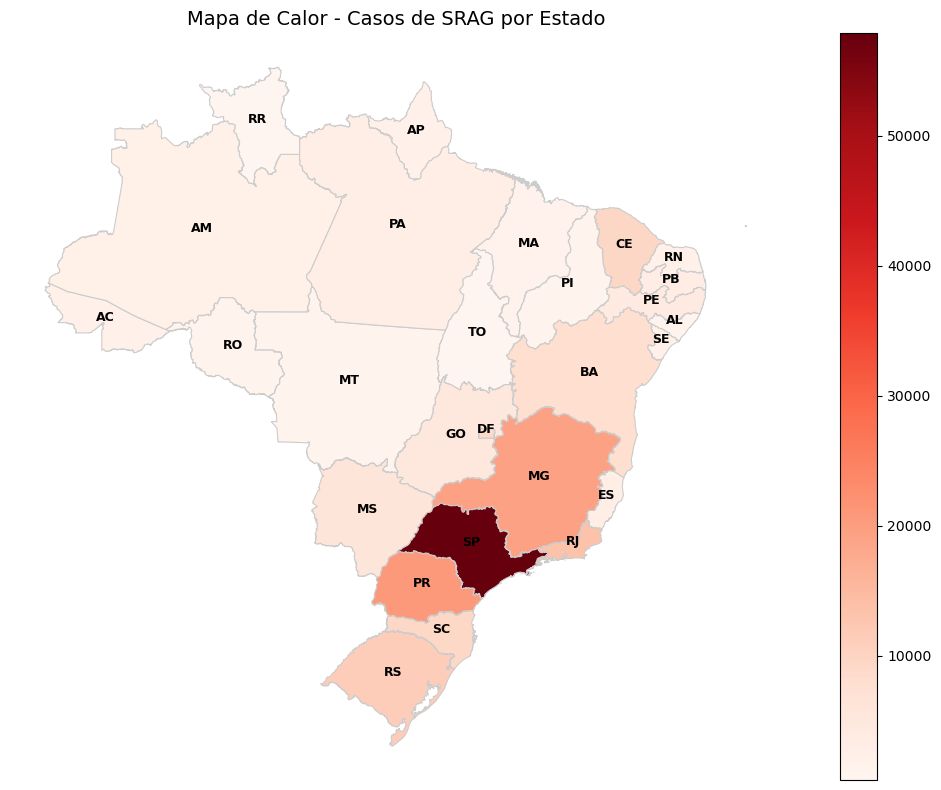

In [15]:
sigla_para_nome = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas', 'BA': 'Bahia',
    'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo', 'GO': 'Goiás',
    'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul', 'MG': 'Minas Gerais',
    'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná', 'PE': 'Pernambuco', 'PI': 'Piauí',
    'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte', 'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina', 'SP': 'São Paulo',
    'SE': 'Sergipe', 'TO': 'Tocantins'
}

# invertando o dicionário para mapear de nome -> sigla
nome_para_sigla = {v: k for k, v in sigla_para_nome.items()}

# realizando a contagem dos casos por sigla
casos_por_estado = X_train['SG_UF_NOT'].value_counts().reset_index()
casos_por_estado.columns = ['SIGLA', 'CASOS']
casos_por_estado['NOME_ESTADO'] = casos_por_estado['SIGLA'].map(sigla_para_nome)

# carregando o GeoJSON dos estados
brasil = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

# realizando o merge usando o nome do estado como referência
brasil = brasil.merge(casos_por_estado, left_on='name', right_on='NOME_ESTADO', how='left')
brasil['CASOS'] = brasil['CASOS'].fillna(0)

# adicionando uma coluna com sigla (para rótulos) dos estados
brasil['SIGLA'] = brasil['name'].map(nome_para_sigla)

# calculo dos centróides para posicionar as siglas
brasil['CENTROIDE'] = brasil.geometry.centroid

# plotando o mapa com siglas de identificação
# adicionando as siglas no centro de cada estado
fig, ax = plt.subplots(figsize=(12, 8))
brasil.plot(column='CASOS', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
for idx, row in brasil.iterrows():
    plt.text(row['CENTROIDE'].x, row['CENTROIDE'].y, row['SIGLA'],
             horizontalalignment='center', fontsize=9, fontweight='bold', color='black')

ax.set_title('Mapa de Calor - Casos de SRAG por Estado', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

Podemos verificar que, a maior quantidade de casos registrados foi no estado de São Paulo, seguidos por Paraná e Minas Gerais. Podemos propor a hipótese de que essa volumetria de casos pode ser devido à grande densidade populacional, principalmente, de São Paulo. Visto que, Alta densidade populacional promove maior interação social e consequentemente maior probabilidade de transmissão.

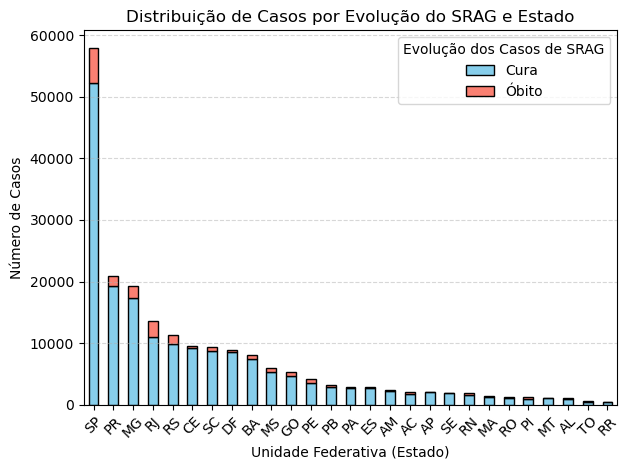

In [16]:
# criando rótulo descritivo para evolução
treino = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
estado = treino[['SG_UF_NOT', 'EVOLUCAO']]
estado['EVOLUCAO_LABEL'] = estado['EVOLUCAO'].map({0: 'Cura', 1: 'Óbito'})

# agrupando por estado e evolução dos casos
estado = estado.groupby(['SG_UF_NOT', 'EVOLUCAO_LABEL']).size().unstack(fill_value=0)

# ordenando estados pelo total de casos
estado = estado.loc[estado.sum(axis=1).sort_values(ascending=False).index]

# plotando o gráfico
estado.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Distribuição de Casos por Evolução do SRAG e Estado')
plt.xlabel('Unidade Federativa (Estado)')
plt.ylabel('Número de Casos')
plt.legend(title='Evolução dos Casos de SRAG')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Apesar da alta taxa de casos encontrados em São Paulo, a volumetria de casos que evoluiram para óbito é baixa, bem como nos outros demais estados.

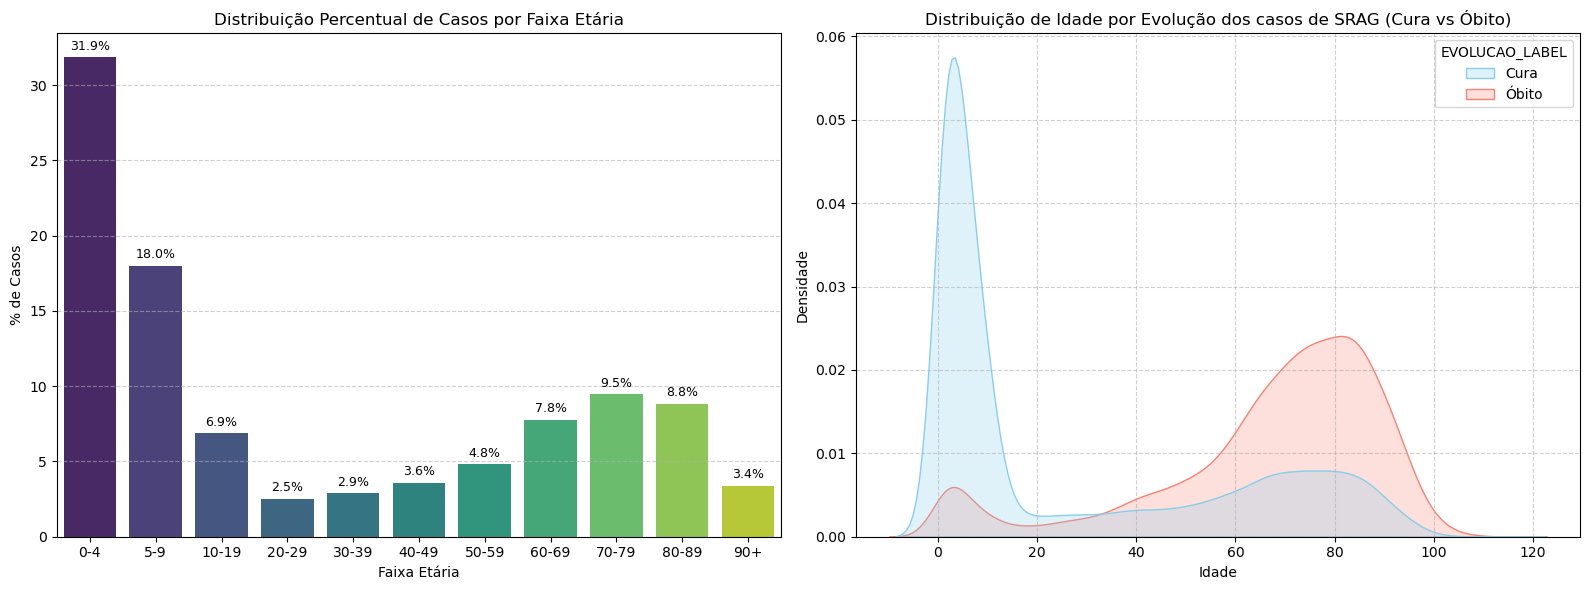

In [17]:
# filtrando idades válidas
idade = treino[(treino['NU_IDADE_N'] >= 0) & (treino['NU_IDADE_N'] <= 120)].copy()

# criando faixas etárias
bins = [0, 4, 9, 19, 29, 39, 49, 59, 69, 79, 89, 120]
labels = ['0-4', '5-9', '10-19', '20-29', '30-39', '40-49',
          '50-59', '60-69', '70-79', '80-89', '90+']
idade['faixa_etaria'] = pd.cut(idade['NU_IDADE_N'], bins=bins, labels=labels, right=True)

# contando casos por faixa etária e adicionando seu valor em porcentagem
faixa_counts = idade['faixa_etaria'].value_counts(sort=False)
faixa_perc = 100 * faixa_counts / faixa_counts.sum()

# mapeamento da evolução conforme o significado da label
idade['EVOLUCAO_LABEL'] = idade['EVOLUCAO'].map({0: 'Cura', 1: 'Óbito'})

# criando subplots para gerar os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# gráfico 1: Distribuição percentual por faixa etária
sns.barplot(x=faixa_perc.index, y=faixa_perc.values, ax=axes[0], palette='viridis')

# adicionando rótulo de porcentagem acima das barras
for i, v in enumerate(faixa_perc.values):
    axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=9)

axes[0].set_title('Distribuição Percentual de Casos por Faixa Etária')
axes[0].set_xlabel('Faixa Etária')
axes[0].set_ylabel('% de Casos')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# gráfico 2: Distribuição de idade x evolução
sns.kdeplot(data=idade, x='NU_IDADE_N', hue='EVOLUCAO_LABEL',
            fill=True, common_norm=False, palette={'Cura': 'skyblue', 'Óbito': 'salmon'},
            ax=axes[1])

axes[1].set_title('Distribuição de Idade por Evolução dos casos de SRAG (Cura vs Óbito)')
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Densidade')
axes[1].grid(True, linestyle='--', alpha=0.6)

# plot dos gráficos
plt.tight_layout()
plt.show()

Podemos verificar que há uma grande incidência de casos infantis, visto que a grande concentração de casos registrados se dá até a idade de 9 anos, havendo outro pico, de menor intensidade, em idades acima de 60 anos.
Pode-se perceber que apesar da elevada quantidade de casos em criaças, verificamos que a letalidade nessa faixa etária é baixa se comparado a faixa etária acima de 60 anos. Podemos levantar a hipótese da debilidade da saúde de pessoas em idades elevadas, mais específicamente terceira idade. Sugerindo políticas de saúde para idosos, como imunização e cuidados de higienização, como por exemplo: lavar as mãos frequentemente e usar de máscaras em ambientes fechado ou com alta densidade de pessoas. Bem como, politicas para prevenção da transmissão entre crianças em escolas, visto que estas podem também contaminar pessoas idosas da família, por exemplo.

Avaliar conforme a data de notificação, DT_NOTIFIC, nos permite traçar o padrão dos casos durante o período de estudo. Portanto, vamos agrupar os casos em períodos de 7 dias, para que então possamos verificar a tendência de aumento/redução dos casos ao longo do ano, permitindo propor hipóteses de correlação, como por exemplo: estação do ano em que as pessoas mais tendem a adquirir, períodos festivos dado que as pessoas possuem mais interações em grandes grupos de pessoas, entre outras possíveis constatações.

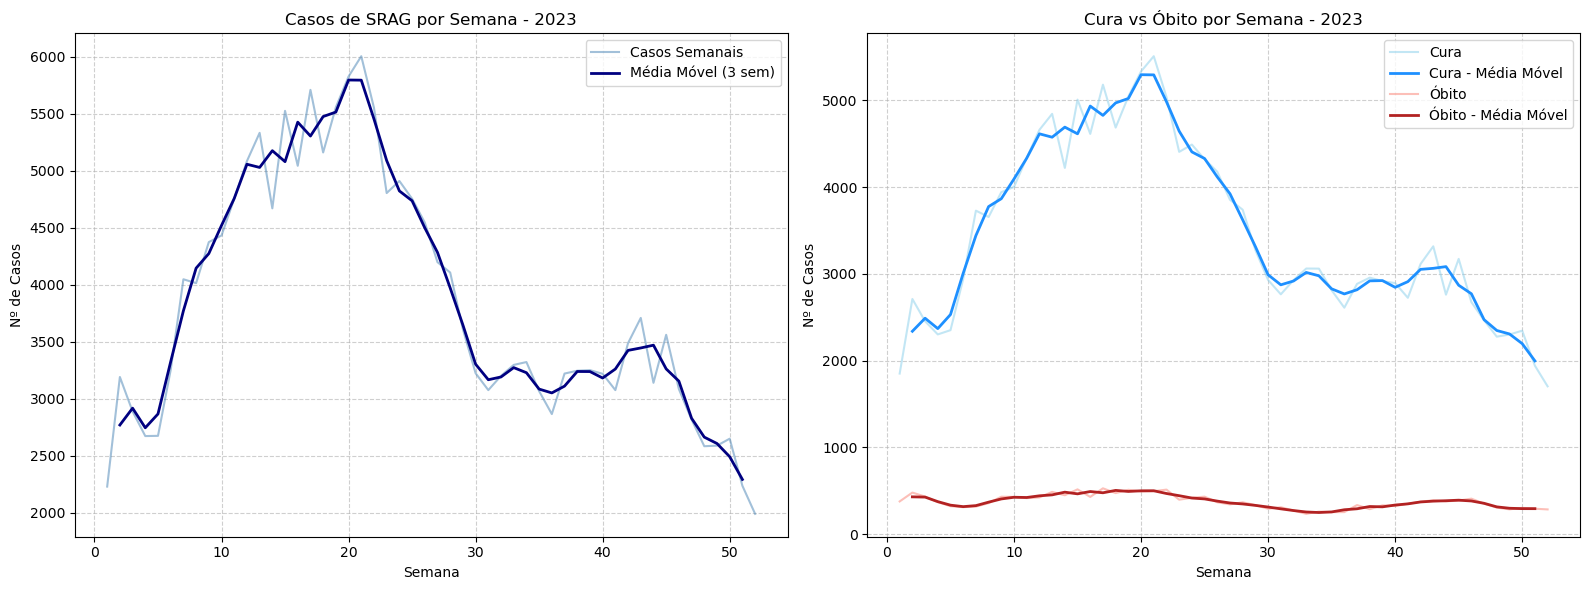

In [18]:
# converte a coluna DT_NOTIFIC para datetime
treino['DT_NOTIFIC'] = pd.to_datetime(treino['DT_NOTIFIC'], errors='coerce')

# filtra apenas o ano de 2023, apenas como uma verificação
srag_2023 = treino[treino['DT_NOTIFIC'].dt.year == 2023].copy()

# agrupando o volume de casos por semana
srag_2023['semana'] = srag_2023['DT_NOTIFIC'].dt.isocalendar().week

# total de casos por semana
casos_por_semana = srag_2023.groupby('semana').size()
casos_por_semana_ma = casos_por_semana.rolling(window=3, center=True).mean()

# casos conforme evolução (cura ou óbito) por semana
srag_2023['EVOLUCAO_LABEL'] = srag_2023['EVOLUCAO'].map({0: 'Cura', 1: 'Óbito'})
casos_semana_evolucao = srag_2023.groupby(['semana', 'EVOLUCAO_LABEL']).size().unstack(fill_value=0)

# criando médias móveis por evolução
casos_evolucao_ma = casos_semana_evolucao.rolling(window=3, center=True).mean()

# criando subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# gráfico 1: total de casos por semana
axes[0].plot(casos_por_semana.index, casos_por_semana.values, label='Casos Semanais', color='steelblue', alpha=0.5)
axes[0].plot(casos_por_semana_ma.index, casos_por_semana_ma.values, label='Média Móvel (3 sem)', color='navy', linewidth=2)
axes[0].set_title('Casos de SRAG por Semana - 2023')
axes[0].set_xlabel('Semana')
axes[0].set_ylabel('Nº de Casos')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# gráfico 2: casos por evolução por semana
axes[1].plot(casos_semana_evolucao.index, casos_semana_evolucao['Cura'], label='Cura', color='skyblue', alpha=0.5)
axes[1].plot(casos_evolucao_ma.index, casos_evolucao_ma['Cura'], label='Cura - Média Móvel', color='dodgerblue', linewidth=2)

axes[1].plot(casos_semana_evolucao.index, casos_semana_evolucao['Óbito'], label='Óbito', color='salmon', alpha=0.5)
axes[1].plot(casos_evolucao_ma.index, casos_evolucao_ma['Óbito'], label='Óbito - Média Móvel', color='firebrick', linewidth=2)

axes[1].set_title('Cura vs Óbito por Semana - 2023')
axes[1].set_xlabel('Semana')
axes[1].set_ylabel('Nº de Casos')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Layout final
plt.tight_layout()
plt.show()

Tivemos um pico de crescimento abrupto dos casos reportados a partir de março, chegando até aproximadamente o final de maio, após este período houve um drastico declínio nos casos até aproximadamente o o final de julho, ocorrendo uma leve oscilação de agosto à outubro, voltando a reduzir significativamente até o fim do ano.

Podemos levantar a hipótese de redução de taxa de adesão à vacinação, baixo incentivo à prevenção com métodos não farmacológicos, como a utilização de máscaras, períodos com clima mais ameno, fazendo com que pessoas ocupem espaços com menor circulação de ar. Quanto a redução dos casos, podemos supor o sucesso da intensificação das políticas públicas de saúde frente ao forte avanço do número de contágios, como visto na nota técnica nº 41/2023, onde reforça a importância das medidas de prevenção e controle das doenças  respiratória, por meios farmacológicos ou não.

A curva quanto a casos de o cura segue o mesmo padrão dos casos notificados, demonstrando uma alta taxa de recuperação, enquanto casos de óbito são baixos e sem grandes oscilações.

Foram utilizados médias móveis para que se pudesse suavizar as curvas, permitindo a verificação de tendências de forma mais assertiva e evitando picos de oscilações aleatórias (ruídos e casos pontuais), tomando como janela o período 3 semanas, utilizando a semana anterior e a posterior à semana avaliada, para o cálculo do valor da média.

Se correlacionarmos as comorbidades e fatores de risco com a evolução nos casos dos pacientes, temos o seguinte:

In [19]:
# os dados sobre comorbidades e demais fatores de risco parecem interessantes, porém com uma baixa qualidade de preenchimento na tabela, portanto, iremos criar uma tabela a parte 
# para analisarmos seus padrões
colunas_fat_risco_comorb_adicionais = ['GARGANTA', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', \
                                       'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', \
                                       'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI']

# selecionando as variaáveis do dataframe original (srag) e juntando apenas com os registros que foram selecionados para treinamento
X_train_extra = srag.loc[X_train.index, colunas_fat_risco_comorb_adicionais]
X_train_extra = pd.concat([X_train, X_train_extra], axis=1)

# conferindo a dimensionalidade do novo dataframe
X_train_extra.shape

(200876, 79)

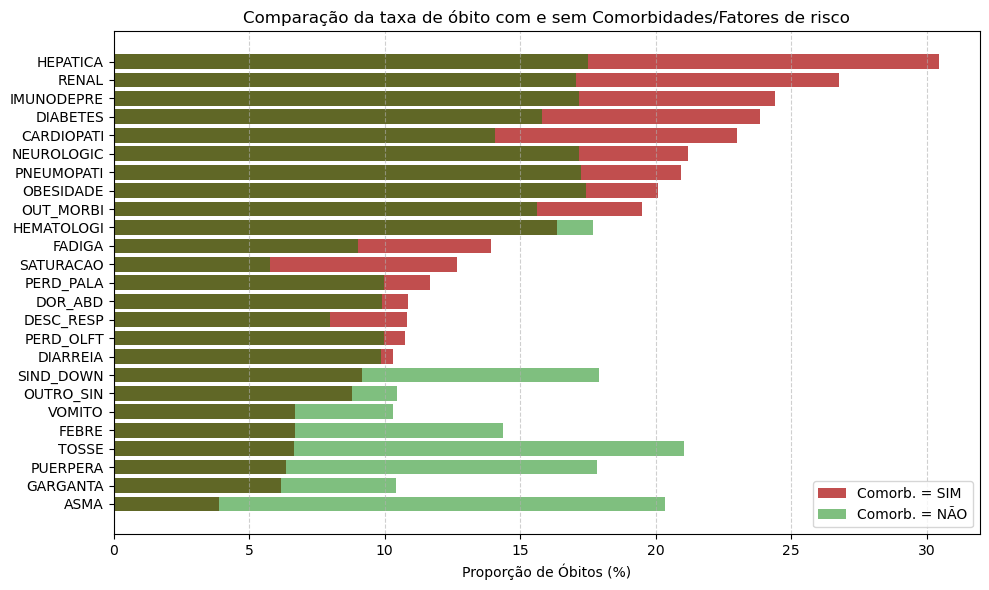

In [20]:
# definindo as colunas de representam comorbidades e fatores de risco
fat_risco_comorb = ['FEBRE', 'TOSSE', 'DESC_RESP', 'GARGANTA', 'DIARREIA', 'VOMITO', 'SATURACAO', 'DOR_ABD', 'FADIGA', \
                    'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', \
                    'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI']

treino_extra = pd.concat([X_train_extra[fat_risco_comorb], y_train], axis = 1)

# definindo comorbidades/fatores de risco analisados e criado um dataframe com informações relacionadas à quantidades
resultados = []

for comorb in fat_risco_comorb:
    grupo = treino_extra[treino_extra[comorb].isin([1, 2])]  # apenas dados válidos
    obitos_com = grupo[(grupo[comorb] == 1) & (grupo['EVOLUCAO'] == 1)].shape[0]
    total_com = grupo[grupo[comorb] == 1].shape[0]

    obitos_sem = grupo[(grupo[comorb] == 2) & (grupo['EVOLUCAO'] == 1)].shape[0]
    total_sem = grupo[grupo[comorb] == 2].shape[0]

    prop_obito_com = obitos_com / total_com if total_com > 0 else 0
    prop_obito_sem = obitos_sem / total_sem if total_sem > 0 else 0

    resultados.append({
        'Comorbidade': comorb,
        'Óbito (%) com comorb.': prop_obito_com * 100,
        'Óbito (%) sem comorb.': prop_obito_sem * 100,
        'Total com comorb.': total_com,
        'Total sem comorb.': total_sem
    })

# gerando um dataframe com as informações
resultado_fat_risco_comorb = pd.DataFrame(resultados).sort_values(by='Óbito (%) com comorb.', ascending=False)

# plotado um gráfico de comparação entre a taxa de óbito de pacientes que possuíam ou não comorbidades/fatores de risco
plt.figure(figsize=(10, 6))
plt.barh(resultado_fat_risco_comorb['Comorbidade'], resultado_fat_risco_comorb['Óbito (%) com comorb.'], color='firebrick', alpha=0.8, label='Comorb. = SIM')
plt.barh(resultado_fat_risco_comorb['Comorbidade'], resultado_fat_risco_comorb['Óbito (%) sem comorb.'], color='green', alpha=0.5, label='Comorb. = NÃO')
plt.xlabel('Proporção de Óbitos (%)')
plt.title('Comparação da taxa de óbito com e sem Comorbidades/Fatores de risco')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

No gráfico acima é mostrado a quantidade em porcentagem de paciêntes que evoluem à óbito quando possuem ou não determinado comorbidade/fator de risco. Há de se ressaltar que, pacientes com problemas de saúde como doeças hepáticas crônicas, doenças renais crônicas, imunodepressão ou imunodeficiência, diabetes e doença cardiovascular crônica, possuem uma alta probabilidade do caso evoluir à óbito, possivelmente por estas doenças serem letais por si só.

Podemos então, sugerir de forma assertiva que esses grupos recebam uma atenção intensificada para prevenção. Em contrapartida, pacientes com doenças menos severas tendem a evoluir à óbito de forma mais branda, como no caso de pacientes que possuem asma ou dores de garganta.

# Pré-processamento dos dados

Passando para o pré-processamento de dados, onde vamos tratar dados ausentes (missing), ajustar os valores preenchidos nas colunas, tratar dados categóricos, padronizar valores e demais tratamentos aos dados selecionados como os que podem ser interessantes para gerar um modelo inicial.

Destacando que todas as transformações serão realizadas de forma explicita neste notebook, para facilitar o entendimento. Portanto, com excessão das funções de pacotes de bibliotecas já conhecidas, não haverão importes de bibliotecas geradas pelo autor.

In [21]:
# as features avaliadas do dataframe srag_reduzidos, que possuem colunas com preenchimento de no mínimo 80%, que serão utilizadas para geração do modelo inicial, serão:
# obs.: as colunas referentes a datas ou informações que aparentemete não agregam valor isoladamente não foram incluídas, porém em hipótese alguma ela estão isentas de 
# apresentar impacto, foi apenas uma escolha para gerar o modelo inicial.
features = ['SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'DESC_RESP', \
            'SATURACAO', 'ANTIVIRAL','HOSPITAL', 'UTI', 'SUPORT_VEN', 'AMOSTRA', 'CLASSI_FIN', 'POV_CT', 'VACINA_COV']

Vamos tratar valores nulos/não informados de algumas features como inclusos na categoria 'NÃO', dados que por vezes os profissionais que fizeram os registros das fichas, podem pular este preechimente dado que o campo pode não ser informado como de essencial preenchimento. Bem como realizar alguns agrupamentos como a feature 'CS_GESTANT', agrupando apenas como SIM ou NÃO, ao invés de separar pelo período da gestação no ato do cadastro do paciente. Quanto a feature de 'CS_SEXO', será criada uma categoria como 'OUTROS' visto que as pessoas que não se enquadram em Masculino ou Feminino podem não ter respondido.

In [22]:
def ajuste_features (df):
    '''
    Função criada para pré-processamento de dados novos, padronizando valores e agrupando em colunas, simplificando seus preenchimentos.
    Ex.: SG_UF_NOT = campos não preenchidos -> 'não informado'
         CS_GESTANT = 1,2,3,4 -> sim e outros -> não
         CS_SEXO = M -> masculino, F -> feminino e demais valores -> outro
         
    '''
    # ajustando unidade federativa, caso não seja informado entrará na categoria 'não informado'
    df['SG_UF_NOT'] = df['SG_UF_NOT'].fillna('não informado')
    # ajustando o código de gestante, resumindo apenas em sim e não, independente do período da gestação
    df['CS_GESTANT'] = df['CS_GESTANT'].apply(lambda x: 'Sim' if x in [1,2,3,4] else 'Não')
    # ajustando sexo para masculino e feminino, não informado serão movidos para categoria 'outro'
    sexo_map = {'M':'masculino', 'F':'feminino'}
    df['CS_SEXO'] = df['CS_SEXO'].map(sexo_map).fillna('outro')
    # ajustando raça para as categorias branca, preta, amarela, parda e indigena, os dados ausentes serão movidos para a categoria 'outra'
    raca_map = {1:'branca', 2:'preta', 3:'amarela', 4:'parda', 5:'indigena'}
    df['CS_RACA'] = df['CS_RACA'].map(raca_map).fillna('outra')
    # ajustando a categoria de classificação da SRAG se foi por influenza, virus, agente etiologico, não especificado e covid-19
    classi_fin_map = {1:'influenza', 2:'vírus', 3:'agente etiologico', 4:'não especificado', 5:'covid-19'}
    df['CLASSI_FIN'] = df['CLASSI_FIN'].map(classi_fin_map).fillna('não especificados')
    # para as demais categorias binárias, estas foram classificadas como sim e não, os dados ausentes foram classificados como não
    lista_colunas = ['AVE_SUINO', 'FEBRE', 'TOSSE', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'ANTIVIRAL', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'AMOSTRA', 'POV_CT', 'VACINA_COV']
    for coluna in lista_colunas:
        geral_map = {1: 'sim', 2:'não'}
        df[coluna] = df[coluna].map(geral_map).fillna('não')

    return df

In [23]:
# vamos separar o que são características categóricas e o que são características númericas, pois elas receberam diferentes tratamentos
feat_categorica = ['SG_UF_NOT', 'CS_SEXO', 'CS_RACA', 'CLASSI_FIN', 'CS_GESTANT', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'DISPNEIA', 'DESC_RESP', \
                   'SATURACAO', 'ANTIVIRAL', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'AMOSTRA', 'POV_CT', 'VACINA_COV']

feat_numerica = ['NU_IDADE_N']

# criando o pipeline de pré-processamento para facilitar a aplicação das transformações tanto no dados de treino, quanto de teste
numerica_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('padronizacao', StandardScaler())
])

categorica_transformer = Pipeline([
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numericos', numerica_transformer, feat_numerica),
    ('categoricos', categorica_transformer, feat_categorica)   
])

pipeline_final = Pipeline([
    ('ajuste incial', FunctionTransformer(ajuste_features, validate = False)),
    ('pré-processamento', preprocessor)
])

In [24]:
# vamos utilizar o pipeline que criamos para automatizar o préprocessamento dos dados que fizemos
X_train_processado = pipeline_final.fit_transform(X_train)
X_test_processado = pipeline_final.transform(X_test)

# Modelagem


Avaliando modelo: Regressão Logística

Avaliação com validação cruzada (5 folds):
ACCURACY  : 0.9173 ± 0.0013
ROC_AUC   : 0.9014 ± 0.0016
AUCPR     : 0.5436 ± 0.0086
PRECISION : 0.6649 ± 0.0101
RECALL    : 0.3336 ± 0.0125
F1        : 0.4442 ± 0.0132

Avaliação no conjunto de teste:
Acurácia     : 0.9158
ROC AUC      : 0.9034
PR AUC (AUCPR): 0.5390
Precisão     : 0.6621
Recall       : 0.3243
F1 Score     : 0.4354

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     45193
         1.0       0.66      0.32      0.44      5026

    accuracy                           0.92     50219
   macro avg       0.80      0.65      0.69     50219
weighted avg       0.90      0.92      0.90     50219

Matriz de Confusão:


array([[44361,   832],
       [ 3396,  1630]])

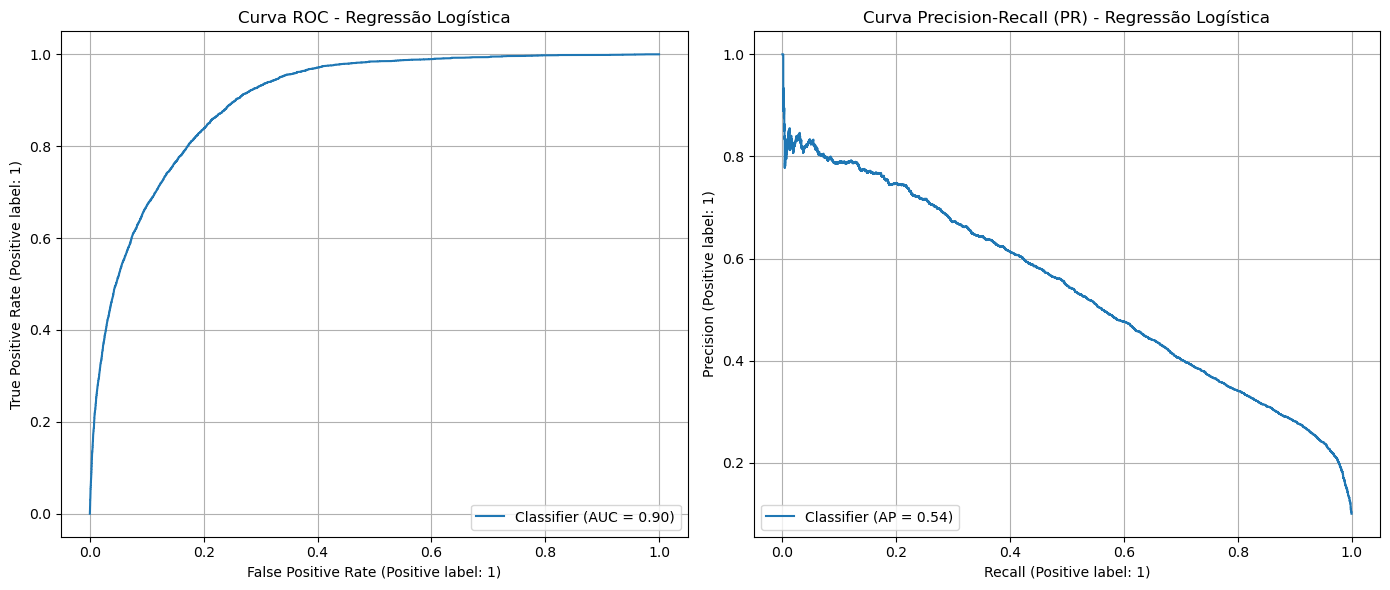


Avaliando modelo: Regressão Logística com balanceamento de classes

Avaliação com validação cruzada (5 folds):
ACCURACY  : 0.7928 ± 0.0011
ROC_AUC   : 0.9016 ± 0.0016
AUCPR     : 0.5408 ± 0.0085
PRECISION : 0.3048 ± 0.0010
RECALL    : 0.8505 ± 0.0046
F1        : 0.4488 ± 0.0013

Avaliação no conjunto de teste:
Acurácia     : 0.7948
ROC AUC      : 0.9035
PR AUC (AUCPR): 0.5367
Precisão     : 0.3095
Recall       : 0.8528
F1 Score     : 0.4541

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87     45193
         1.0       0.31      0.85      0.45      5026

    accuracy                           0.79     50219
   macro avg       0.64      0.82      0.66     50219
weighted avg       0.91      0.79      0.83     50219

Matriz de Confusão:


array([[35629,  9564],
       [  740,  4286]])

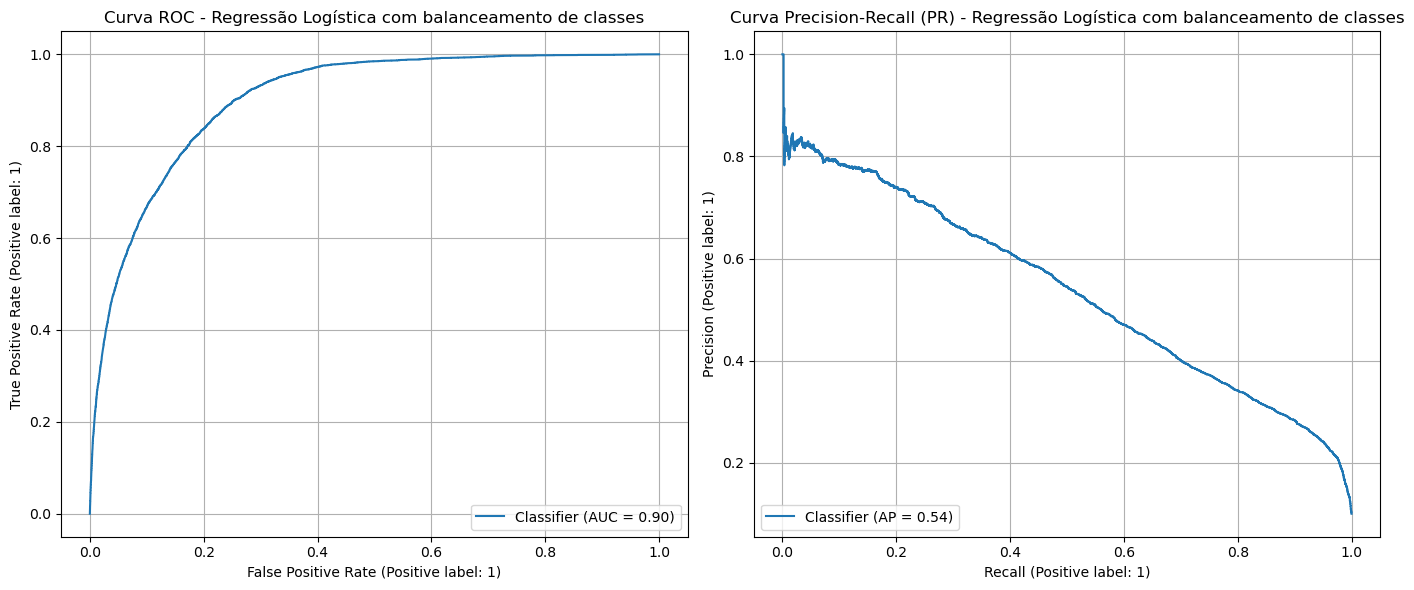


Avaliando modelo: Árvore de Decisão

Avaliação com validação cruzada (5 folds):
ACCURACY  : 0.7161 ± 0.0092
ROC_AUC   : 0.8817 ± 0.0026
AUCPR     : 0.4643 ± 0.0118
PRECISION : 0.2457 ± 0.0048
RECALL    : 0.8989 ± 0.0114
F1        : 0.3858 ± 0.0050

Avaliação no conjunto de teste:
Acurácia     : 0.7062
ROC AUC      : 0.8845
PR AUC (AUCPR): 0.4659
Precisão     : 0.2430
Recall       : 0.9150
F1 Score     : 0.3841

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81     45193
         1.0       0.24      0.92      0.38      5026

    accuracy                           0.71     50219
   macro avg       0.61      0.80      0.60     50219
weighted avg       0.91      0.71      0.76     50219

Matriz de Confusão:


array([[30868, 14325],
       [  427,  4599]])

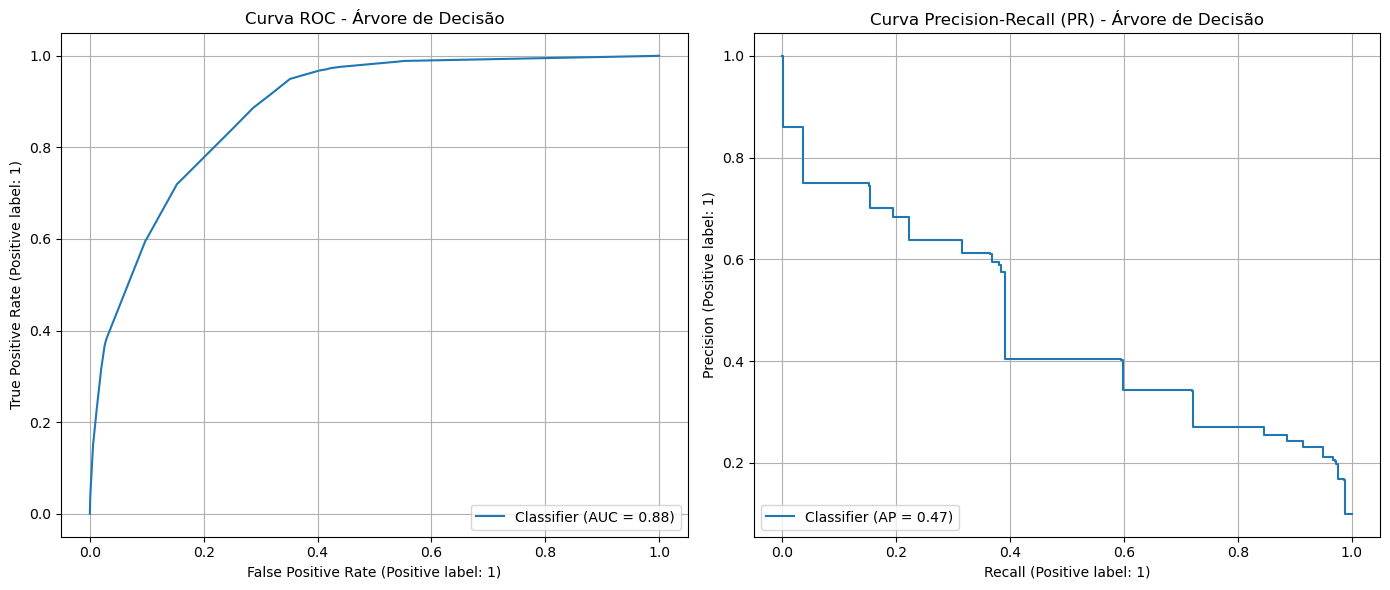


Avaliando modelo: Random Forest

Avaliação com validação cruzada (5 folds):
ACCURACY  : 0.7379 ± 0.0044
ROC_AUC   : 0.8866 ± 0.0021
AUCPR     : 0.4951 ± 0.0077
PRECISION : 0.2590 ± 0.0028
RECALL    : 0.8826 ± 0.0074
F1        : 0.4004 ± 0.0030

Avaliação no conjunto de teste:
Acurácia     : 0.7327
ROC AUC      : 0.8900
PR AUC (AUCPR): 0.4969
Precisão     : 0.2577
Recall       : 0.8890
F1 Score     : 0.3996

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     45193
         1.0       0.26      0.89      0.40      5026

    accuracy                           0.73     50219
   macro avg       0.62      0.80      0.61     50219
weighted avg       0.91      0.73      0.79     50219

Matriz de Confusão:


array([[32325, 12868],
       [  558,  4468]])

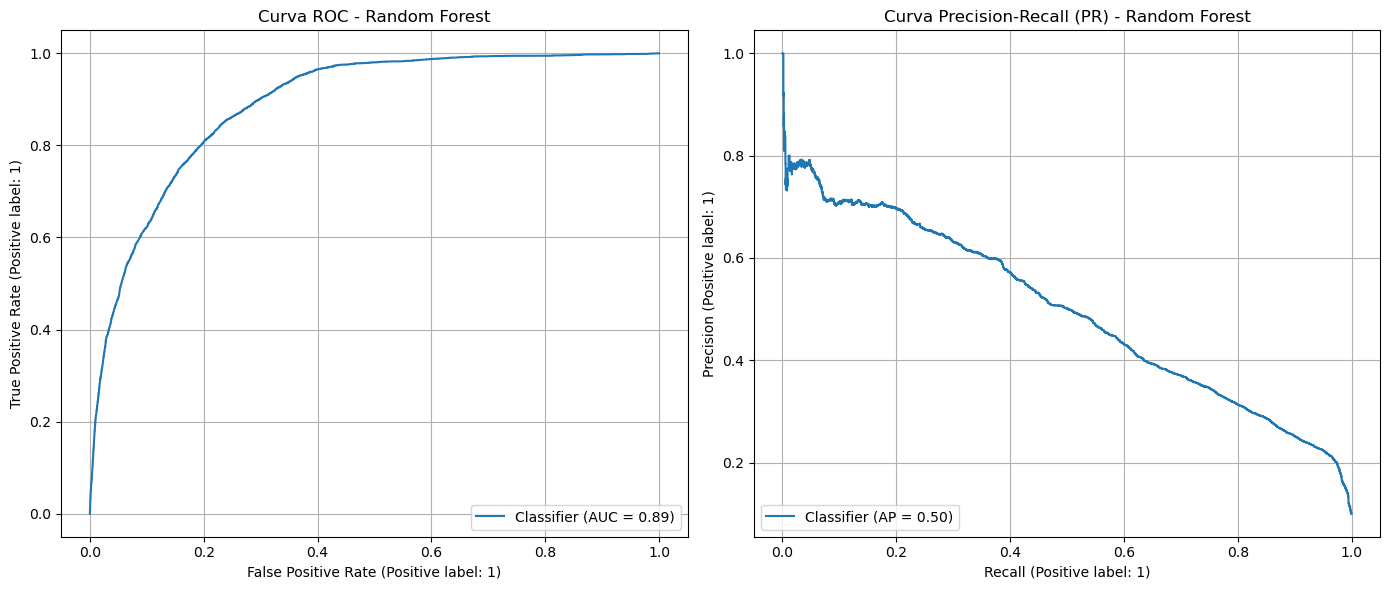

In [25]:
# como as classes do objeto de estudo são desbalanceadas, uma técnica que permite punir a performance do modelo, caso ele erre a classe minoritária é o class weight.
peso_classe = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
peso_dict = {classe: peso for classe, peso in zip(np.unique(y_train), peso_classe)}

# scorers personalizados
scorers = {
    'accuracy': 'accuracy',
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'aucpr': make_scorer(average_precision_score, needs_proba=True),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# modelos a serem avaliados
modelos = {
    'Regressão Logística': LogisticRegression(penalty='none', max_iter=1000, random_state=42),
    'Regressão Logística com balanceamento de classes': LogisticRegression(penalty='none', max_iter=1000, class_weight=peso_dict, random_state=42),
    'Árvore de Decisão': DecisionTreeClassifier(criterion='gini', min_samples_leaf=5, max_depth=5, class_weight=peso_dict, random_state=42),
    'Random Forest': RandomForestClassifier(criterion='gini', min_samples_leaf=5, max_depth=5, class_weight=peso_dict, random_state=42)
}

# automatizando o teste de cada modelo
for nome, modelo in modelos.items():
    print(f"\nAvaliando modelo: {nome}")

    # avaliação com cross_val_score (treino)
    resultados = {}
    for metrica, scorer in scorers.items():
        score = cross_val_score(modelo, X_train_processado, y_train, cv=5, scoring=scorer)
        resultados[metrica] = (score.mean(), score.std())

    # treinamento e avaliação de performance do modelo
    modelo.fit(X_train_processado, y_train)
    y_pred = modelo.predict(X_test_processado)
    y_proba = modelo.predict_proba(X_test_processado)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    aucpr = average_precision_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\nAvaliação com validação cruzada (5 folds):")
    for metrica, (media, std) in resultados.items():
        print(f"{metrica.upper():<10}: {media:.4f} ± {std:.4f}")

    print("\nAvaliação no conjunto de teste:")
    print(f"Acurácia     : {acc:.4f}")
    print(f"ROC AUC      : {roc:.4f}")
    print(f"PR AUC (AUCPR): {aucpr:.4f}")
    print(f"Precisão     : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # matriz de confusão
    print("Matriz de Confusão:")
    display(confusion_matrix(y_test, y_pred))

    # gráficos das curvas AUCROC e AUCPR
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axs[0])
    axs[0].set_title(f'Curva ROC - {nome}')
    axs[0].grid(True)

    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axs[1])
    axs[1].set_title(f'Curva Precision-Recall (PR) - {nome}')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    print("=" * 100)


# Avaliação dos modelos

# Conclusão

A partir deste estudo, podemos sugerir políticas públicas assertivas com base no maior número de casos da sindrome respiratória aguda grave que evoluiram para óbito. Começando com o reforço sobre métodos farmacológicos ou não farmacológicos, conforme já noticiado pela nota técnica nº 41/2023. Atenção sobre a contaminação em escolas, dados que a maior população notificada apresentava até 9 anos de idade, mesmo que seus indíces de cura sejam elevados, pois elas possivelmente contaminarão seus tutores, o que é significativamente relevante dado que a taxa de óbito para a população idosa é elevada.

Apesar do estado de São Paulo apresenntar um alto grau de notificações, a taxa de óbito é relativamente baixa se comparado ao percentual de pacientes curados, este alto grau de notificações em SP nos leva a ponderar que talvez outros estados mais pobres podem não possuir infraestrutura suficente para identificar e reportar todos os casos. Logo, uma médida urgente seria a capacitação dos profissionais, bem como fornecimento de infraestrutura adequada.

Observamos um pico de crescimento abrupto dos casos reportados a partir de março, chegando até aproximadamente o final de maio, após este período houve um drastico declínio nos casos até aproximadamente o o final de julho, ocorrendo uma leve oscilação de agosto à outubro, voltando a reduzir significativamente até o fim do ano. Podendo pressupor uma ação urgente do governos que promoveu esse declive elevado.

Foi observado também, que doenças hepáticas e renais crônicas, bem como doenças imunodeficientes ou imunodeprecivas, possuem uma alta letalidade como quando comparado a pacientes que não às possuem. O que ressalta a necessidade de tratamentos não somente em casos com SRAG, mas para prevenção dessas doenças de forma geral.

Alcançamos um resultado satisfatório com um modelo de arvore de decisão, este que possui uma alta explicabilidade, o que facilita para informar resultados preditos bem como discutir possíveis melhoras no mesmo.